
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Max Weight Search

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, tqdm, scipy, functools, collections, copy
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import localizing, modelHandlers, dataLoaders, gradient

## Model

In [2]:
model_type = "gpt-neo-125M"
model = modelHandlers.load_model(model_type=model_type, DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']


## Load Data

In [3]:
train_dl, test_dl = dataLoaders.batched_pile(mem_batch=5, non_mem_batch=10, test_frac=0.0)
#dl = dataLoaders.batched_pop_seqs(model, mem_batch=5, non_mem_batch=10)

## Search Weights

In [6]:
def batched_c_type_collection(model, dl, run_fwd_bwd, c_types:list=["W_Q","W_K","W_V","W_O","W_in","W_out"], n_batches:int=10, norm_by_batch:bool=True):
    """
    summing all gradient weights in component c_type over multiple batches
    """
    weight_gradients = collections.defaultdict(torch.tensor)
    for batch_i, (c_toks_NI, k_toks_NI) in tqdm.tqdm(enumerate(dl)):
        fwd_cache, bwd_cache = run_fwd_bwd(model, c_toks_NI.squeeze(0), k_toks_NI.squeeze(0))
        for c_type in c_types:
            if c_type in ["W_Q","W_K","W_V","W_O","W_in","W_out"]: ## model params
                c_vals, c_names = localizing.collect_c_type(model=model, cache=None, c_type=c_type)
            elif c_type in ["q","k","v","o","mlp_in","mlp_out"]: ## activation
                c_vals, c_names = localizing.collect_c_type(model=model, cache=bwd_cache, c_type=c_type)
            else:
                raise Exception(f"No eligible parameter oder activation name passed: {c_types}")
                
            ## Summing up values___________________________
            c_vals = c_vals.detach() 
            if norm_by_batch:
                c_vals = c_vals / n_batches
            if batch_i == 0:
                weight_gradients[c_type] = c_vals 
            else:
                weight_gradients[c_type] += c_vals 
        if batch_i+1 == n_batches: ## break early
            return weight_gradients
    return weight_gradients
 
c_types=["W_in", "W_out", "W_Q", "W_K", "W_V", "W_O"]
fwd_bwd = functools.partial(gradient.run_fwd_bwd, after_I=0, with_mse=True,pool={"c":[-1],"k":[0,-1]})
c_grads = batched_c_type_collection(model, train_dl, fwd_bwd, c_types=c_types, n_batches=2)
localizing.store_data(c_grads, f"results/{model_type}/{'_'.join(c_types)}.pt")

0it [00:00, ?it/s]

contrast_res: 0.8127433657646179, c_nll: 0.8127433657646179, k_nll: 0.0


1it [00:05,  5.42s/it]

returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])
returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
contrast_res: 0.5995692610740662, c_nll: 0.5995692610740662, k_nll: 0.0


1it [00:10, 10.83s/it]

returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])
returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])


stored data at /home/jupyter/paraMem/results/gpt-neo-125M/W_in_W_out_W_Q_W_K_W_V_W_O.pt


In [10]:
def get_topK_grads(c_grads:dict, topK:int=100, select_c:list=None, select_l:list=None, select_heads:list=[], return_lk:bool=False, largest:bool=True, select_random:bool=False):
    """
    weight_gradients is a list of tensors, collect topK weight gradients and return as layer-wise list and in original shape
    """
    c_grads = copy.deepcopy(c_grads)
    ## (1) prepare components and layers
    n_layers = list(c_grads.values())[0].shape[0]
    if select_l is None or len(select_l) == 0:
        select_l = list(range(n_layers))
    remove_layers = list(range(n_layers))
    remove_layers = list(set(remove_layers).difference(set(select_l)))
    if select_c is None or len(select_c) == 0:
        select_c = list(c_grads.keys())
        
    ## (2) gather the top gradients
    c_top_grads = {}
    for c_type,c_vals in c_grads.items():
        if c_type in select_c:
            if len(select_heads) > 0 and len(c_vals.shape) >= 4: ##select specific head from attention component 
                c_vals = c_vals[:,torch.LongTensor(select_heads),:,:]
            gradients_ld = c_vals.view(c_vals.shape[0],-1) ## flatten tensor to l_dim and model_dim
            gradients_ld[torch.LongTensor(remove_layers),:] = gradients_ld[torch.LongTensor(remove_layers),:]*0 ## filter layers based on select_layers criterion  
            if select_random==False: ## normal topK selection mode
                weight_scores, weight_idcs = torch.topk(gradients_ld.flatten(), topK, largest=largest)
            else: ## selecting any random weights as a baseline
                random_idcs = torch.randperm(gradients_ld.flatten().shape[0])
                weight_scores, weight_idcs = gradients_ld.flatten()[random_idcs[:topK]], random_idcs[:topK].squeeze()
            weight_idcs = torch.tensor(np.array(np.unravel_index(weight_idcs.numpy(), gradients_ld.shape))).T
            c_top_grads[c_type]={"idcs": weight_idcs, "scores": weight_scores}

            if return_lk: ## reformat the output to return layer-wise list of lists
                weight_ids_lk = [[] for l in range(n_layers)]
                weight_scores_lk = [[] for l in range(n_layers)]
                for k, weight_idx in enumerate(weight_idcs):
                    weight_ids_lk[weight_idx[0]].append(weight_idx[1].item())
                    weight_scores_lk[weight_idx[0]].append(weight_scores[k].item())
                c_top_grads[c_type]={"idcs": weight_ids_lk, "scores": weight_scores_lk}
    return c_top_grads

c_top_grads = get_topK_grads(c_grads, topK=100, select_c=["W_Q","W_V"], select_l=[2], select_heads=[11], return_lk=False, largest=True, select_random=False)
c_top_grads

{'W_Q': {'idcs': tensor([[    2, 38896],
          [    2, 38872],
          [    2, 38903],
          [    2, 38849],
          [    2, 38860],
          [    2, 41456],
          [    2, 38878],
          [    2, 38864],
          [    2, 38875],
          [    2, 38892],
          [    2, 18992],
          [    2,  5329],
          [    2, 38876],
          [    2, 38899],
          [    2, 38859],
          [    2, 41432],
          [    2, 38893],
          [    2, 38884],
          [    2, 41463],
          [    2, 38877],
          [    2, 41409],
          [    2, 44656],
          [    2, 38898],
          [    2, 41420],
          [    2,  5325],
          [    2, 38868],
          [    2, 38895],
          [    2, 41438],
          [    2, 38853],
          [    2, 18968],
          [    2, 41424],
          [    2, 38866],
          [    2, 41435],
          [    2, 18999],
          [    2,  5353],
          [    2, 38858],
          [    2, 18945],
          [    2, 38873

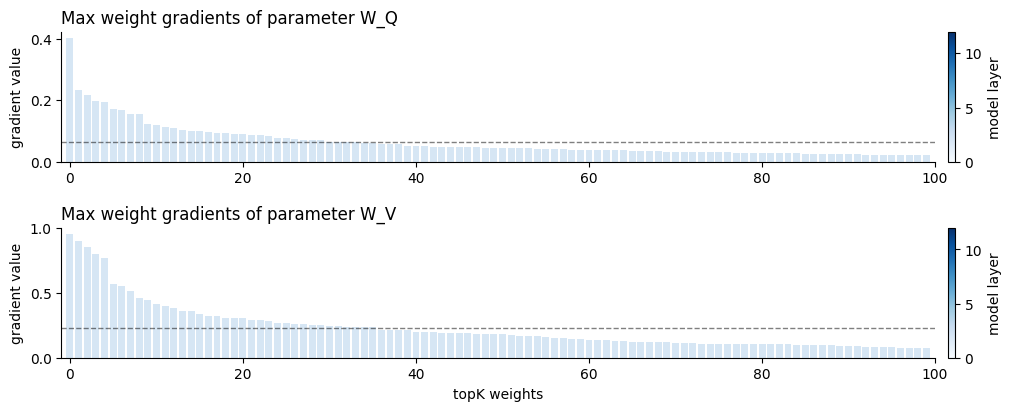

In [11]:
def plot_max_gradients(c_top_grads:dict, topK:int=None, n_layers:int=11):
    """
    plotting the max gradients in model component and coloring by layer index
    """
    fig, axs = plt.subplots(len(c_top_grads.keys()), 1, figsize=(10, 4), gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, constrained_layout=True)
    fontsize=10
    
    cmap = plt.cm.Blues
    norm = mpl.colors.Normalize(0, n_layers)

    for i, (c_type, idcs_scores) in enumerate(c_top_grads.items()):
        scores = c_top_grads[c_type]["scores"][:topK]
        layers = c_top_grads[c_type]["idcs"][:,0][:topK]
        colors = cmap(norm(layers))
        
        bars = axs[i].bar(np.arange(0,len(scores)),scores, color=colors)
        axs[i].axhline(y=scores.mean(), color='r', linewidth=1, linestyle='--', c="black", alpha=0.5)
        
        axs[i].set_title(f"Max weight gradients of parameter {c_type}", loc="left", fontsize=fontsize+2)
        axs[i].set_ylabel('gradient value', color='black', fontsize=fontsize)
        if i == len(c_top_grads.keys())-1:
            axs[i].set_xlabel('topK weights', color='black', fontsize=fontsize)
        axs[i].set_xlim(-1, len(scores))
        
        scalarmappaple = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        scalarmappaple.set_array(layers.tolist())
        plt.colorbar(scalarmappaple, ax=axs[i], label="model layer", pad=-0.0)


plot_max_gradients(c_top_grads, n_layers=model.cfg.n_layers)